In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, despine
from spatial_maps.fields import (
    find_peaks, calculate_field_centers, separate_fields_by_laplace, 
    map_pass_to_unit_circle, calculate_field_centers, distance_to_edge_function, 
    in_field, compute_crossings)
from spike_statistics.core import permutation_resampling

import scipy.signal as ss
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

In [3]:
%matplotlib notebook
# %matplotlib inline

In [4]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "phase-precession"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [5]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,burst_event_ratio,bursty_spike_ratio,gridness,border_score,information_rate,information_specificity,head_mean_ang,head_mean_vec_len,spacing,orientation
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.398230,0.678064,-0.466923,0.029328,1.009215,0.317256,5.438033,0.040874,0.628784,20.224859
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.138014,0.263173,-0.666792,0.308146,0.192524,0.033447,1.951740,0.017289,0.789388,27.897271
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.373986,0.659259,-0.572566,0.143252,4.745836,0.393704,4.439721,0.124731,0.555402,28.810794
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.087413,0.179245,-0.437492,0.268948,0.157394,0.073553,6.215195,0.101911,0.492250,9.462322
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.248771,0.463596,-0.085938,0.218744,0.519153,0.032683,1.531481,0.053810,0.559905,0.000000


In [6]:
statistics['unit_day'] = statistics.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [7]:
stim_response_action = actions['stimulus-response']
stim_response_results = pd.read_csv(stim_response_action.data_path('results'))

In [8]:
statistics = pd.merge(statistics, stim_response_results, how='left')

In [9]:
print('N cells:',statistics.shape[0])

N cells: 1284


In [10]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [11]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,p_e_peak,t_i_peak,p_i_peak,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.332548,0.229073,6.029431,0.205362,1.115825,0.066736,0.451741
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.354830,0.089333,6.120055,0.073566,0.223237,0.052594,0.098517
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.264610,-0.121081,5.759406,0.150827,4.964984,0.027120,0.400770
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.344280,0.215829,6.033364,0.110495,0.239996,0.054074,0.269461
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.342799,0.218967,5.768170,0.054762,0.524990,0.144702,0.133410


# Statistics about all cell-sessions

In [12]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

# Find all cells with gridness above threshold

In [13]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


## select neurons that have been characterized as a grid cell on the same day

In [14]:
once_a_gridcell = statistics[statistics.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [15]:
print("Number of gridcells", once_a_gridcell.unit_idnum.nunique())
print("Number of gridcell recordings", len(once_a_gridcell))
print("Number of animals", len(once_a_gridcell.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 231
Number of animals 4


# divide into stim not stim

In [16]:
baseline_i = once_a_gridcell.query('baseline and Hz11')
stimulated_11 = once_a_gridcell.query('stimulated and frequency==11 and stim_location=="ms"')

baseline_ii = once_a_gridcell.query('baseline and Hz30')
stimulated_30 = once_a_gridcell.query('stimulated and frequency==30 and stim_location=="ms"')

print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 66
Number of gridcells in stimulated 11Hz ms sessions 61
Number of gridcells in baseline ii sessions 56
Number of gridcells in stimulated 30Hz ms sessions 40


# Plotting

In [17]:
max_speed = .5 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

speed_binsize = 0.02

stim_mask = True
baseline_duration = 600

In [18]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, 
    stim_mask=stim_mask, baseline_duration=baseline_duration
)

In [294]:
n1 = baseline_i.sort_values('gridness', ascending=False).iloc[2]

# candidates
# 4
# wierd
# 5

In [295]:
lfp = data_loader.lfp(n1.action, n1.channel_group)

In [296]:
spikes = data_loader.spike_train(n1.action, n1.channel_group, n1.unit_name)

In [297]:
rate_map = data_loader.rate_map(n1.action, n1.channel_group, n1.unit_name, smoothing=0.04)

In [298]:
pos_x, pos_y, pos_t, pos_speed = map(data_loader.tracking(n1.action).get, ['x', 'y', 't', 'v'])

In [299]:
spikes = np.array(spikes)

In [300]:
spikes = spikes[(spikes > pos_t.min()) & (spikes < pos_t.max())]

<IPython.core.display.Javascript object>


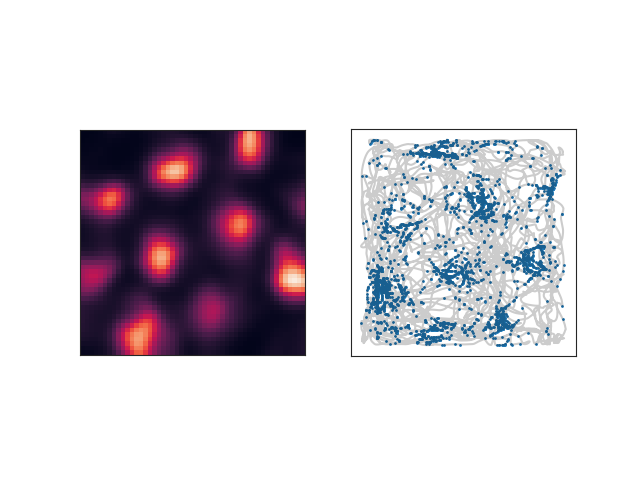

In [301]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(rate_map, origin='lower')
axs[1].plot(pos_x, pos_y, color='k', alpha=.2)
axs[1].scatter(interp1d(pos_t, pos_x)(spikes), interp1d(pos_t, pos_y)(spikes), s=1)
for ax in axs:
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])

In [303]:
def find_grid_fields(rate_map):
    # find fields with laplace
    fields_laplace = sp.fields.separate_fields_by_dilation(rate_map, sigma=3)
    fields = fields_laplace.copy() # to be cleaned by Ismakov
    fields_areas = scipy.ndimage.measurements.sum(
        np.ones_like(fields), fields, index=np.arange(fields.max() + 1))
    fields_area = fields_areas[fields]
    fields[fields_area < 9.0] = 0

    # find fields with Ismakov-method
    fields_ismakov, radius = sp.separate_fields_by_distance(rate_map)
    fields_ismakov_real = fields_ismakov * bin_size
    approved_fields = []

    # remove fields not found by both methods
    for point in fields_ismakov:
        field_id = fields[tuple(point)]
        approved_fields.append(field_id)

    for field_id in np.arange(1, fields.max() + 1):
        if not field_id in approved_fields:
            fields[fields == field_id] = 0
            
    return fields

In [304]:
fields = find_grid_fields(rate_map)

In [305]:
field_centers = calculate_field_centers(rate_map, fields, center_method='center_of_mass')

In [306]:
sx,sy   = fields.shape
# bin sizes
dx      = box_size[0]/sx
dy      = box_size[1]/sy
assert dx == dy

In [307]:
field_centers * dx

array([[0.34850787, 0.42672288],
       [0.74106107, 0.91752797],
       [0.13451885, 0.965316  ],
       [0.6884345 , 0.56474887],
       [0.95189656, 0.03822667],
       [0.95574102, 0.65912767],
       [0.40784051, 0.80619233],
       [0.2571891 , 0.07907471],
       [0.92925175, 0.32989048],
       [0.05832719, 0.34251465],
       [0.11429355, 0.67647967],
       [0.5707286 , 0.18130422]])

In [308]:
field_indices = np.unique(fields.ravel())[1:]

<IPython.core.display.Javascript object>


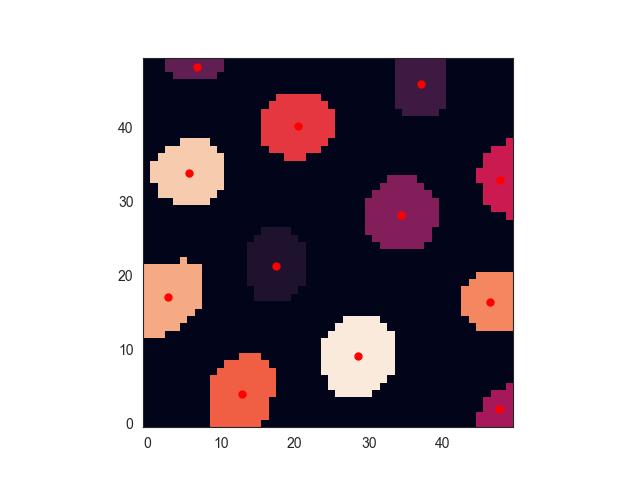

In [309]:
plt.figure()
plt.imshow(fields, origin='lower')
for xc, yc in field_centers:
    plt.plot(xc, yc, marker='.', markersize=10, color='r')

In [310]:
in_field_indices = in_field(pos_x, pos_y, fields, box_size)

In [311]:
in_field_enter, in_field_exit = compute_crossings(in_field_indices)

In [312]:
%matplotlib notebook

<IPython.core.display.Javascript object>


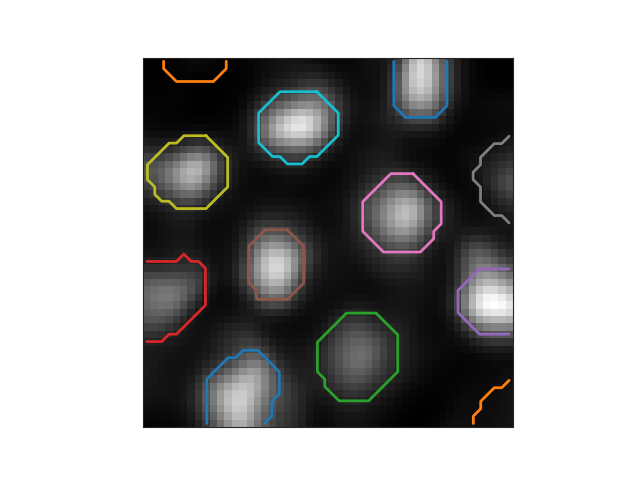

[]

In [313]:
from skimage import measure
contours = measure.find_contours(fields, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(rate_map, cmap=plt.cm.gray, origin='lower')

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

In [314]:
def normalize(a):
    _a = a - a.min()
    return _a / _a.max()

In [315]:
def distance(x, y):
    _x = x - x.min()
    _y = y - y.min()
    dx, dy = np.diff(x), np.diff(y)
    s = np.sqrt(dx**2 + dy**2)
    distance = np.cumsum(s) 
    # first index is distance from first point, 
    # to match len(x) we put a zero as first index to initialize distance 0
    return np.concatenate(([0], distance))

<IPython.core.display.Javascript object>


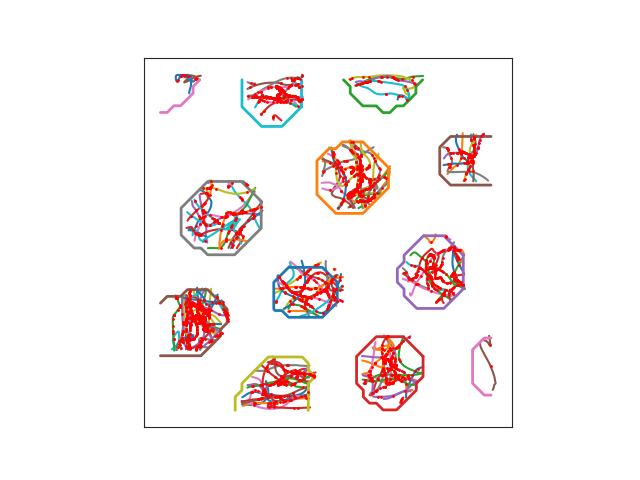

[]

In [316]:
in_field_spikes, in_field_dur, in_field_dist = [], [], []
fig, ax = plt.subplots()
sx, sy = interp1d(pos_t, pos_x), interp1d(pos_t, pos_y)
for en, ex in zip(in_field_enter, in_field_exit):
    x, y, t = pos_x[en:ex+1], pos_y[en:ex+1], pos_t[en:ex+1]
    
    s = spikes[(spikes > t[0]) & (spikes < t[-1])]
    if len(s) == 0:
        continue
    in_field_spikes.append(s)
    dist = distance(x, y)
    t_to_dist = interp1d(t, normalize(dist))
    in_field_dist.append(t_to_dist(s))
    t_to_dur = interp1d(t, normalize(t))
    in_field_dur.append(t_to_dur(s))
    ax.plot(x, y)
    ax.scatter(sx(s), sy(s), s=1, color='r', zorder=100000)
    
for n, contour in enumerate(contours):
    ax.plot(contour[:, 0] * dx, contour[:, 1] * dy, linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

In [317]:
distances = []
pdmds = []
pdcds = []
for (xc, yc), fidx in zip(field_centers * dx, field_indices):
    if any(np.isnan([xc, yc])):
        continue
    r, a, pdcd, pdmd = map_pass_to_unit_circle(
        pos_x, pos_y, pos_t, xc, yc, field=np.where(fields==fidx, fields, fields*0), 
        box_size=box_size)
    distances.append(r)
    pdmds.append(pdmd)
    pdcds.append(pdcd)

In [318]:
distances = np.array(distances)
pdmds = np.array(pdmds)
pdcds = np.array(pdcds)

In [319]:
pdmds

array([[-7.54404366, -7.54625297, -7.5481222 , ...,  5.78420658,
         5.8351289 ,  5.88223834],
       [-3.71974814, -3.71990056, -3.7200183 , ..., -2.11933041,
        -2.11283199, -2.10664347],
       [-0.49634739, -0.49637622, -0.49639849, ..., -0.19319857,
        -0.19197042, -0.1908011 ],
       ...,
       [-0.01741735, -0.01780761, -0.01829799, ...,  0.94586019,
         0.94976158,  0.95347049],
       [-0.40912211, -0.40916547, -0.40919902, ...,  0.04205379,
         0.04393686,  0.04572904],
       [-0.19813494, -0.19819508, -0.1982413 , ...,  0.41389043,
         0.43410654,  0.4566706 ]])

<IPython.core.display.Javascript object>


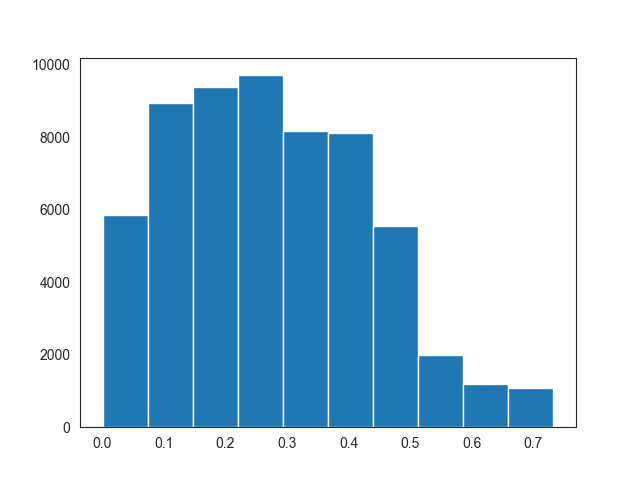

(array([5858., 8933., 9393., 9711., 8161., 8112., 5556., 1985., 1203.,
        1085.]),
 array([4.02268559e-04, 7.36266440e-02, 1.46851019e-01, 2.20075395e-01,
        2.93299770e-01, 3.66524146e-01, 4.39748521e-01, 5.12972896e-01,
        5.86197272e-01, 6.59421647e-01, 7.32646023e-01]),
 <a list of 10 Patch objects>)

In [320]:
plt.figure()
plt.hist(np.nanmin(distances, axis=0))

In [322]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [323]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)


def remove_artifacts(anas, spikes=None, width=500, threshold=2, sampling_rate=None, fillval=0):
    sampling_rate = sampling_rate or anas.sampling_rate.magnitude
    times = np.arange(anas.shape[0]) / sampling_rate
    anas = np.array(anas)
    if anas.ndim == 1:
        anas = np.reshape(anas, (anas.size, 1))
    assert len(times) == anas.shape[0]
    nchan = anas.shape[1]
    if spikes is not None:
        spikes = np.array(spikes)
    for ch in range(nchan):
        idxs, = np.where(abs(anas[:, ch]) > threshold)
        for idx in idxs:
            if spikes is not None:
                t0 = times[idx-width]
                stop = idx+width
                if stop > len(times) - 1:
                    stop = len(times) - 1 
                t1 = times[stop]
                mask = (spikes > t0) & (spikes < t1)
                spikes = spikes[~mask]
            anas[idx-width:idx+width, ch] = fillval
    if spikes is not None:
        return anas, times, spikes
    else:
        return anas, times

<IPython.core.display.Javascript object>


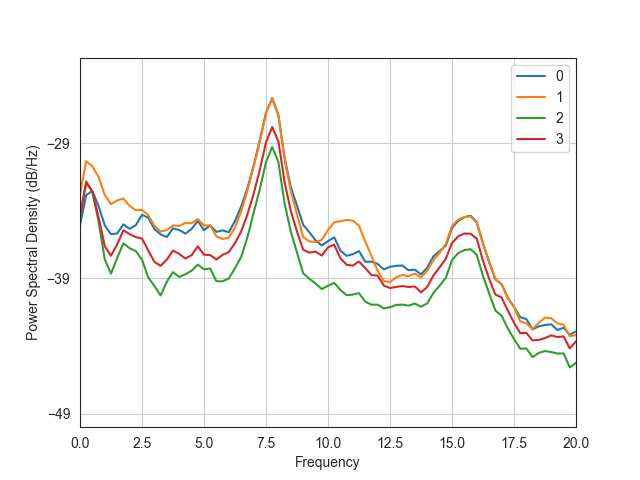

In [324]:
plt.figure()
cleaned_lfp_, times_ = remove_artifacts(lfp)
for i, ch in enumerate(cleaned_lfp_.T):
    plt.psd(ch, Fs=lfp.sampling_rate.magnitude, NFFT=4000, label=f'{i}')
plt.xlim(0,20)
plt.ylim(-50)
plt.legend()

In [325]:
filtered_lfp = butter_bandpass_filter(lfp.magnitude[:,1], 6, 10, fs=lfp.sampling_rate.magnitude, order=3)

In [326]:
cleaned_lfp, times, cleaned_spikes = remove_artifacts(
    filtered_lfp, spikes, threshold=2, sampling_rate=lfp.sampling_rate.magnitude, fillval=0)

In [327]:
cleaned_lfp = cleaned_lfp.ravel()

<IPython.core.display.Javascript object>


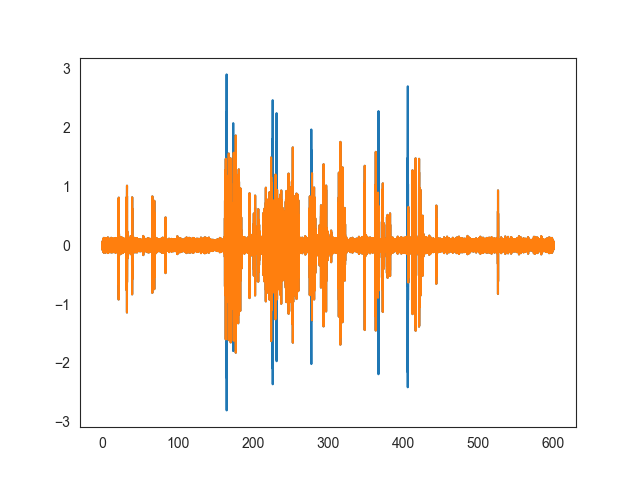

In [328]:
plt.figure()
plt.plot(times, filtered_lfp)
plt.plot(times, cleaned_lfp)

<IPython.core.display.Javascript object>


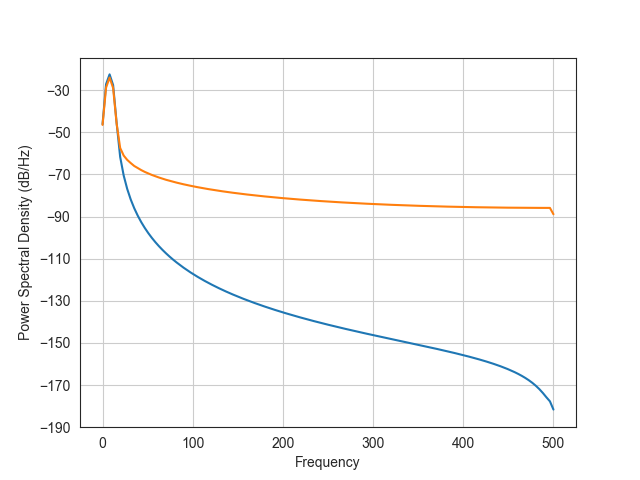

In [329]:
plt.figure()
plt.psd(filtered_lfp, Fs=lfp.sampling_rate.magnitude);
plt.psd(cleaned_lfp[~np.isnan(cleaned_lfp)], Fs=lfp.sampling_rate.magnitude);

In [330]:
# plt.figure()
# plt.plot(times, cleaned_lfp)
# for s in cleaned_spikes:
#     plt.axvline(s, color='r')

In [331]:
def compute_spike_phase(lfp, times, return_degrees=False):
    x_a = ss.hilbert(lfp)
    x_phase = np.angle(x_a)
    if return_degrees:
        x_phase = x_phase * 180 / np.pi
    return interp1d(times, x_phase)

In [332]:
def compute_isi_trials(spikes, min_isi=(962 - 834) / 1000):
    isis = np.diff(cleaned_spikes)
    isi_shift = np.concatenate(([0], isis < min_isi)).astype(int)
    starts, = np.where(np.diff(isi_shift) == 1)
    stops, = np.where(np.diff(isi_shift) == -1)
    return starts, stops

In [333]:
spike_phase_func = compute_spike_phase(cleaned_lfp, times)

In [334]:
from septum_mec.analysis.plotting import regplot

<IPython.core.display.Javascript object>


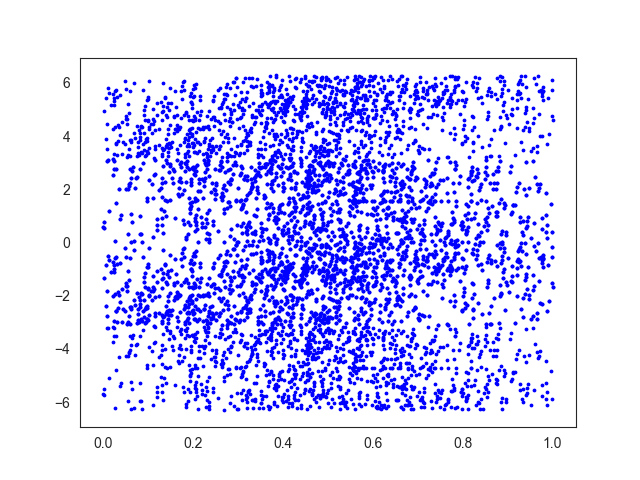

In [335]:
fig, ax = plt.subplots()
dot_size = 3
for i, s in enumerate(in_field_spikes):
    if len(s) <= 2:
        continue
    spike_phase = spike_phase_func(s)
#     regplot(normalize(s), spike_phase_func(s), ax=ax, ci=0, color='b')
#     ax.scatter(in_field_dur[i], spike_phase, color='b', s=dot_size)
#     ax.scatter(in_field_dur[i], spike_phase % (2*np.pi), color='b', s=dot_size)
#     ax.scatter(in_field_dur[i], spike_phase % (-2*np.pi), color='b', s=dot_size)
    
#     regplot(in_field_dist[i], spike_phase_func(s), ax=ax, ci=0, color='b')
    ax.scatter(in_field_dist[i], spike_phase, color='b', s=dot_size)
    ax.scatter(in_field_dist[i], spike_phase % (2*np.pi), color='b', s=dot_size)
    ax.scatter(in_field_dist[i], spike_phase % (-2*np.pi), color='b', s=dot_size)
#     if i > 20:
#         break
# plt.xlim(0,1)

In [ ]:
spike_phase = compute_spike_phase(cleaned_lfp, times)(cleaned_spikes)

In [ ]:
starts, stops = compute_isi_trials(cleaned_spikes)

In [ ]:
trials_phases = []
trials_times = []
trials_times_aligned = []
for start, stop in zip(starts, stops):
    trials_phases.append(spike_phase[start:stop])
    s = cleaned_spikes[start:stop]
    trials_times.append(s)
    trials_times_aligned.append(s - s[0])

In [ ]:
plt.figure()
plt.plot(times, cleaned_lfp)
for trial in trials_times:
    plt.plot(trial, np.zeros_like(trial), ls='none', marker='|', markersize=1000)

In [ ]:
plt.figure()
for phase, time in zip(trials_phases, trials_times_aligned):
    plt.scatter(time, phase, s=2, c='b')
    plt.scatter(time, phase  % (2*np.pi), s=2, c='b')

In [ ]:
plt.figure()
plt.hist(spike_phase, bins=100);

In [ ]:
spike_dist = interp1d(pos_t, distances.min(0))(cleaned_spikes)
plt.scatter(spike_dist, spike_phase, s=2, c='b')
plt.scatter(spike_dist, spike_phase  % (2*np.pi), s=2, c='b')

In [ ]:
for pdmd in pdmds:
    plt.scatter(interp1d(pos_t, pdmd)(cleaned_spikes), spike_phase, s=.1, color='b')

plt.xlim(-1,1)

In [ ]:
for pdcd in pdcds:
    plt.scatter(interp1d(pos_t, pdcd)(cleaned_spikes), spike_phase, s=.1, color='b')
plt.xlim(-1,1)

In [ ]:
for d in distances:
    plt.scatter(interp1d(pos_t, d)(cleaned_spikes), spike_phase, s=.1, color='b')

plt.xlim(0,1)